In [41]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import tables as tb
from astropy.coordinates.angle_utilities import angular_separation
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from astropy.table import Table, Column
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVR
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

In [29]:
def extract_df(root_filename):
    particle_file = uproot.open(root_filename)
    data = particle_file["data"]
    cuts = particle_file["fEventTreeCuts"]

    # Cut 1: Events surviving gamma/hadron separation and direction cuts:
    mask_gamma_like_and_direction = cuts.array('CutClass') == 5

    # Cut 2: Events surviving gamma/hadron separation cut and not direction cut:
    mask_gamma_like_no_direction = cuts.array('CutClass') == 0

    gamma_like_events = np.logical_or(mask_gamma_like_and_direction, mask_gamma_like_no_direction)
    mc_energy = data.array("MCe0")[gamma_like_events]  # mc_energy = tb.Float32Col(dflt=np.nan, pos=7)

    # Variables for regression:
    mc_alt = 90 - data.array("MCze")[gamma_like_events]
    mc_az = data.array("MCaz")[gamma_like_events]
    reco_alt = 90 - data.array("Ze")[gamma_like_events]  # reco_alt = tb.Float32Col(dflt=np.nan, pos=9)
    reco_az = data.array("Az")[gamma_like_events]  # reco_az = tb.Float32Col(dflt=np.nan, pos=10)
    # Angular separation bewteen the true vs reconstructed direction
    ang_diff = angular_separation(
        mc_az * u.deg,  # az
        mc_alt * u.deg,  # alt
        reco_az * u.deg,
        reco_alt * u.deg,
    )

    # Variables for training:
    av_size = [np.average(sizes) for sizes in data.array("size")[gamma_like_events]]       
    reco_energy = data.array("ErecS")[gamma_like_events]  
    NTels_reco = data.array("NImages")[gamma_like_events]
    x_cores = data.array('Xcore')[gamma_like_events]
    y_cores = data.array('Ycore')[gamma_like_events]
    array_distance = np.sqrt(x_cores**2. + y_cores**2.)
    x_off = data.array('Xoff')[gamma_like_events]
    y_off = data.array('Yoff')[gamma_like_events]
    camera_offset = np.sqrt(x_off**2. + y_off**2.)
    img2_ang = data.array('img2_ang')[gamma_like_events]
    EChi2S = data.array('EChi2S')[gamma_like_events]
    SizeSecondMax = data.array('SizeSecondMax')[gamma_like_events]
    NTelPairs = data.array('NTelPairs')[gamma_like_events]
    MSCW = data.array('MSCW')[gamma_like_events]
    MSCL = data.array('MSCL')[gamma_like_events]
    # Bin in reconstructed energy, and calculate percentiles (in this case 4 event types):
    event_types = np.zeros_like(reco_energy)
    log_e_reco_bins = np.linspace(-2., 2.5, 40)
    for i, log_e_high in enumerate(log_e_reco_bins):
        if i is 0:
            continue
        e_low = 10**log_e_reco_bins[i-1]
        e_high = 10**log_e_high
        # Select events within the rec. energy bin:
        events = np.logical_and(reco_energy > e_low, reco_energy < e_high)
        # Make sure there are events:
        if not np.sum(events) > 0:
            continue
        p1 = np.percentile(ang_diff[events], 25)
        p2 = np.percentile(ang_diff[events], 50)
        p3 = np.percentile(ang_diff[events], 75)
        event_types[np.logical_and(events, ang_diff < p1)] = 0
        event_types[np.logical_and(np.logical_and(events, ang_diff >= p1), ang_diff < p2)] = 1
        event_types[np.logical_and(np.logical_and(events, ang_diff >= p2), ang_diff < p3)] = 2
        event_types[np.logical_and(events, ang_diff >= p3)] = 3
    # Build astropy table:
    t = Table()
    t['log_ang_diff'] = np.log10(ang_diff.value)
    # t['log_av_size'] = np.log10(av_size)
    t['log_reco_energy'] = np.log10(reco_energy)
    t['log_NTels_reco'] = np.log10(NTels_reco)
    t['array_distance'] = array_distance
    t['img2_ang'] = img2_ang
    # t['log_EChi2S'] = np.log10(EChi2S)
    t['log_SizeSecondMax'] = np.log10(SizeSecondMax)
#     t['camera_offset'] = camera_offset
    # t['log_NTelPairs'] = np.log10(NTelPairs)
    # t['MSCW'] = MSCW
    # t['MSCL'] = MSCL
#     t['event_types'] = event_types
    return t.to_pandas()

In [30]:
dtf = extract_df("gamma_onSource.S.3HB9-FD_ID0.eff-0.root")
# dtf = extract_df("gamma_cone.S.3HB9-FD_ID0.eff-1.root")


In [31]:
train_feature = "log_ang_diff"
result_scores = dict()

In [32]:
## split data
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.85)## print info
X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
           'img2_ang', 'log_SizeSecondMax']
X_train = dtf_train[X_names].values
y_train = dtf_train[train_feature].values
X_test = dtf_test[X_names].values
y_test = dtf_test[train_feature].values

print("X_train shape:", dtf_train.drop(train_feature,axis=1).shape, "| X_test shape:", 
      dtf_test.drop(train_feature,axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train[train_feature]),2), "| y_test mean:", 
      round(np.mean(dtf_test[train_feature]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop(train_feature,axis=1).columns.to_list())

X_train shape: (280103, 5) | X_test shape: (1587252, 5)
y_train mean: -3.05 | y_test mean: -3.05
6 features: ['log_reco_energy', 'log_NTels_reco', 'array_distance', 'img2_ang', 'log_SizeSecondMax']


In [26]:
## scale X
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X = scalerX.fit_transform(dtf_train.drop(train_feature, axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop(train_feature, 
                                                   axis=1).columns, index=dtf_train.index)## scale Y
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
dtf_scaled[train_feature] = scalerY.fit_transform(dtf_train[train_feature].values.reshape(-1,1))
dtf_scaled.head()

,log_reco_energy,log_NTels_reco,array_distance,img2_ang,log_SizeSecondMax,camera_offset,event_types
1703630,-0.694794,-0.678072,-0.477741,-1.141977,0.027476,2.994357,0.333333
1290395,0.091596,0.000000,0.439219,0.601387,-0.262925,-0.419748,-0.666667
424883,-0.008037,0.321928,0.203887,0.398638,-0.237204,0.377744,0.333333
1389976,-0.807546,-1.000000,-0.232839,-5.065455,-0.963759,7.303369,0.333333
1397778,-0.437203,0.000000,-0.381051,-0.314703,0.308877,0.165185,-0.333333


Text(0.5, 1.0, 'pearson correlation')

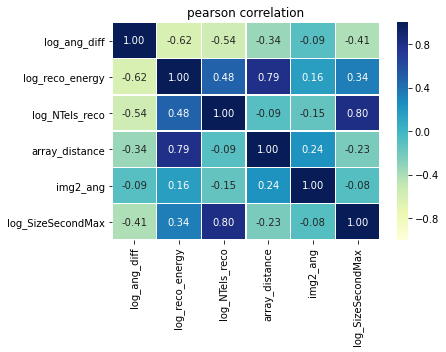

In [15]:
corr_matrix = dtf_train.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

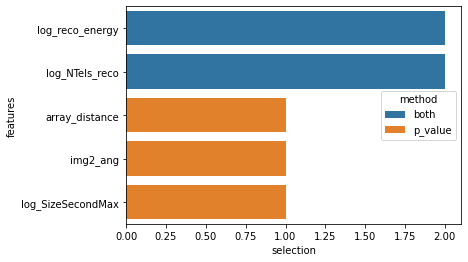

In [16]:
X = dtf_train.drop(train_feature, axis=1).values
y = dtf_train[train_feature].values
feature_names = dtf_train.drop(train_feature, axis=1).columns## p-value
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_regression, k=5).fit(X,y)
pvalue_selected_features = feature_names[selector.get_support()]

## regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.Ridge(alpha=1.0, fit_intercept=True), 
                                 max_features=5).fit(X,y)
regularization_selected_features = feature_names[selector.get_support()]
 
## plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["p_value"] = dtf_features["features"].apply(
    lambda x: "p_value" if x in pvalue_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(
    lambda x: 1 if x in pvalue_selected_features else 0)
dtf_features["regularization"] = dtf_features["features"].apply(
    lambda x: "regularization" if x in regularization_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(
    lambda x: 1 if x in regularization_selected_features else 0)
dtf_features["method"] = dtf_features[["p_value","regularization"]].apply(
    lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
dtf_features["method"] = dtf_features["method"].apply(
    lambda x: "both" if len(x.split()) == 2 else x)

sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", 
                                                                                     ascending=False), 
            dodge=False)

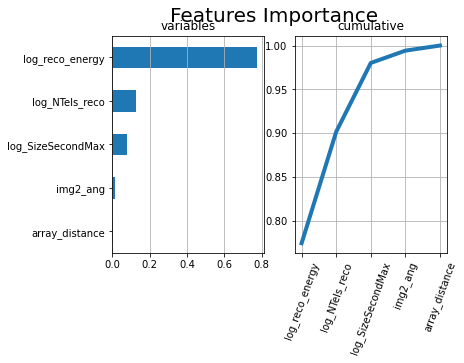

In [17]:
X = dtf_train.drop(train_feature, axis=1).values
y = dtf_train[train_feature].values
feature_names = dtf_train.drop(train_feature, axis=1).columns.tolist()## call model
model = ensemble.GradientBoostingRegressor()## Importance
model.fit(X,y)
importances = model.feature_importances_## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

In [34]:
["{}".format(a) for a in np.arange(0,4,1)]

['0', '1', '2', '3']

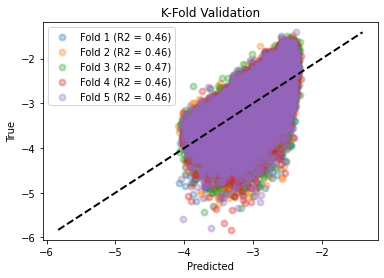

In [18]:
## call model
model = linear_model.LinearRegression()## K fold validation
scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

In [33]:
# importing necessary libraries 
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 

dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)## print info

X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
           'img2_ang', 'log_SizeSecondMax']
X_train = dtf_train[X_names].values
y_train = dtf_train[train_feature].values
X_test = dtf_test[X_names].values
y_test = dtf_test[train_feature].values
  
# dividing X, y into train and test data 
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 
  
# training a DescisionTreeClassifier 
dtree_model = RandomForestRegressor(n_estimators=20, random_state=0, n_jobs=4,
                                    verbose=True).fit(X_train, y_train) 
y_pred = dtree_model.predict(X_test) 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.8s finished


No handles with labels found to put in legend.


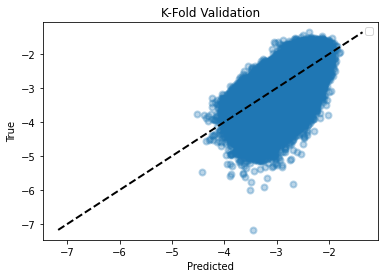

In [34]:
plt.scatter(y_pred, y_test, lw=2, alpha=0.3, 
            label='')
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

In [27]:
y_pred

array([-2.5750973 , -2.99493702, -3.59621232, ..., -2.06125173,
       -2.00174924, -3.84188656])

In [25]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 4.520199630112161e-05
Mean Squared Error: 7.186210747747687e-08
Root Mean Squared Error: 0.00026807108661225826


In [ ]:
dtree_predictions

0.0 0
0.010 < E < 0.017
0.0 1
0.017 < E < 0.030
0.0 2
0.030 < E < 0.051
0.0 3
0.051 < E < 0.089
1.0 0
0.089 < E < 0.153
1.0 1
0.153 < E < 0.264
1.0 2
0.264 < E < 0.455
1.0 3
0.455 < E < 0.785
2.0 0
0.785 < E < 1.354
2.0 1
1.354 < E < 2.336
2.0 2
2.336 < E < 4.030
2.0 3
4.030 < E < 6.952
3.0 0
6.952 < E < 11.994
3.0 1
11.994 < E < 20.691
3.0 2
20.691 < E < 35.697
3.0 3
35.697 < E < 61.585
4.0 0
61.585 < E < 106.247
4.0 1
106.247 < E < 183.298
4.0 2
183.298 < E < 316.228


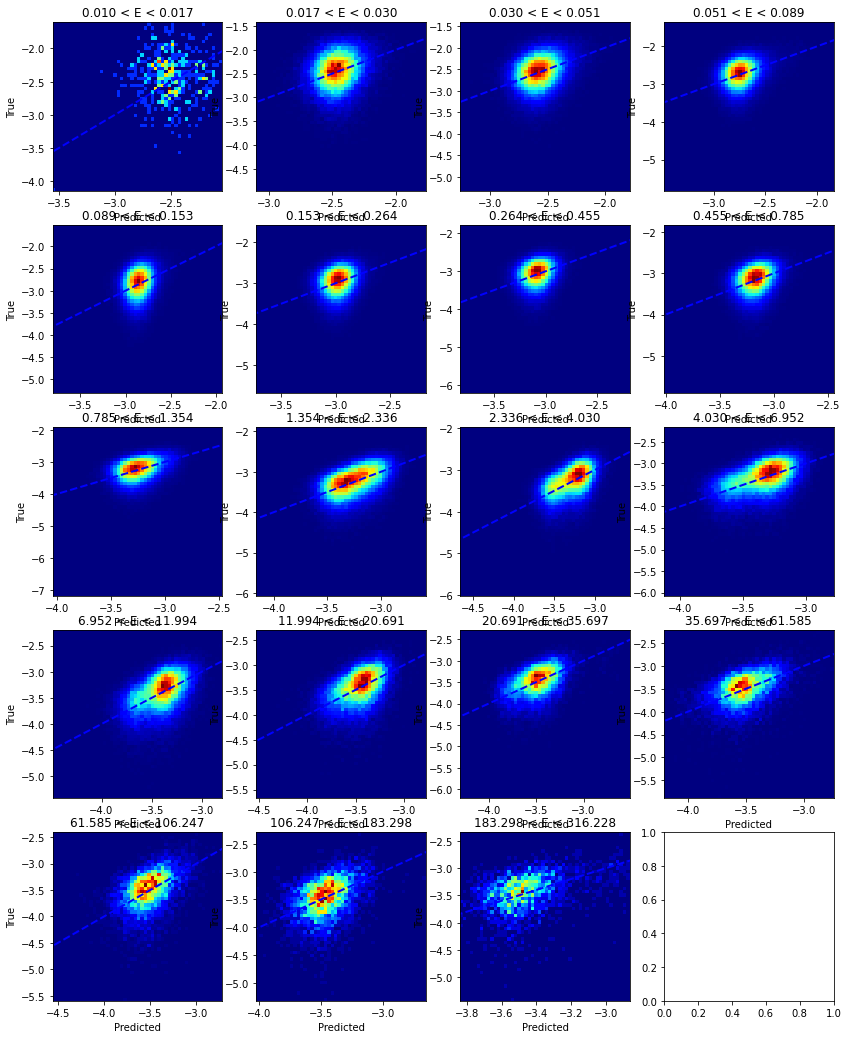

In [45]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 18])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)
rf_scores = []
for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
    dtree_model = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=4).fit(X_train, y_train) 
    y_pred = dtree_model.predict(X_test) 
    # Big bins
    ax.hist2d(y_pred, y_test, bins=(50, 50), range=[[-6, -2], [-6,-2]], cmap=plt.cm.jet)
#     ax.scatter(y_pred, y_test, lw=2, alpha=0.3, label='')
    ax.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)],
             linestyle='--', lw=2, color='blue')
    ax.set_title("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    score = round(dtree_model.score(X_test, y_test), 4)
    print("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    rf_scores.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
plt.show()
result_scores['RandomForestRegressor_100'] = rf_scores.copy()

0.0 0
0.010 < E < 0.017
Root Mean Squared Error: 0.36254719098550064
0.0 1
0.017 < E < 0.030
Root Mean Squared Error: 0.3511230766887642
0.0 2
0.030 < E < 0.051
Root Mean Squared Error: 0.3417943303166625
0.0 3
0.051 < E < 0.089
Root Mean Squared Error: 0.32430847855022343
1.0 0
0.089 < E < 0.153
Root Mean Squared Error: 0.31549326646351233
1.0 1
0.153 < E < 0.264
Root Mean Squared Error: 0.310344437402878
1.0 2
0.264 < E < 0.455
Root Mean Squared Error: 0.30605389378697256
1.0 3
0.455 < E < 0.785
Root Mean Squared Error: 0.3041872359459845
2.0 0
0.785 < E < 1.354
Root Mean Squared Error: 0.30087423026300525
2.0 1
1.354 < E < 2.336
Root Mean Squared Error: 0.30202207672701914
2.0 2
2.336 < E < 4.030
Root Mean Squared Error: 0.30256242316024945
2.0 3
4.030 < E < 6.952
Root Mean Squared Error: 0.3001391118806929
3.0 0
6.952 < E < 11.994
Root Mean Squared Error: 0.29903538616695413
3.0 1
11.994 < E < 20.691
Root Mean Squared Error: 0.3008493729598692
3.0 2
20.691 < E < 35.697
Root Mean Sq

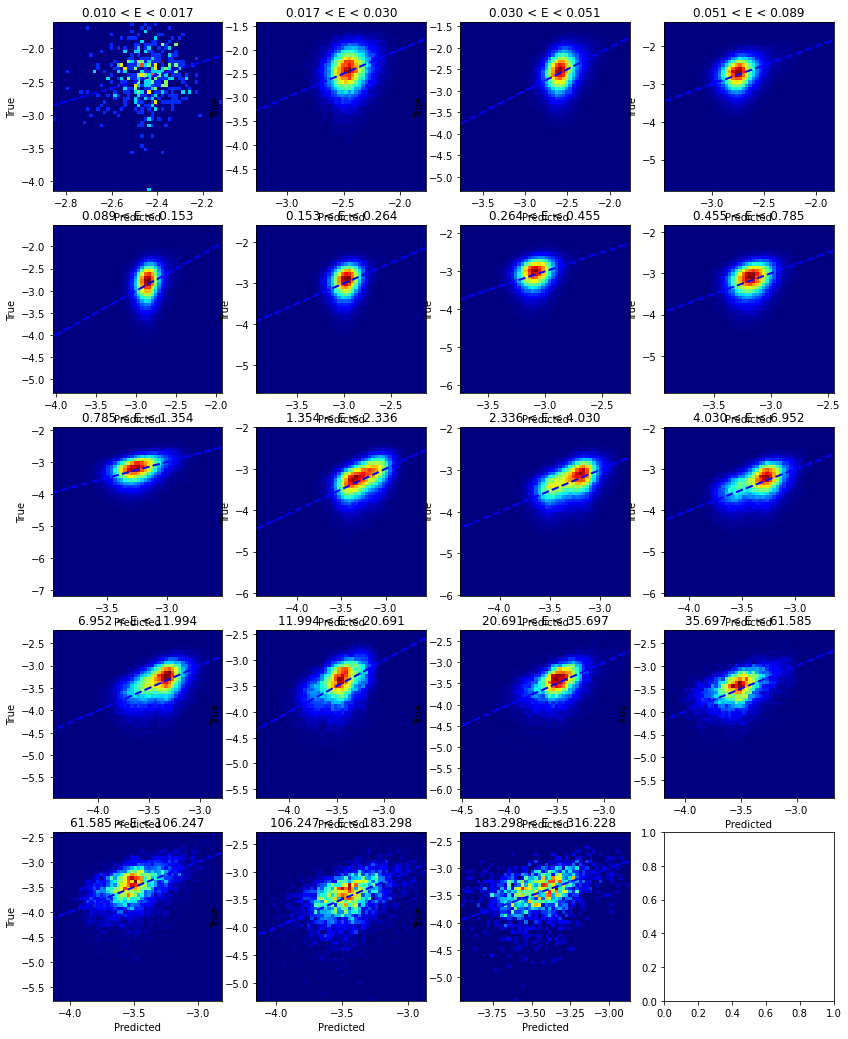

In [46]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 18])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)
rf_scores = []
for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
    dtree_model = RandomForestRegressor(n_estimators=200, random_state=0, n_jobs=4).fit(X_train, y_train) 
    y_pred = dtree_model.predict(X_test) 
    # Big bins
    ax.hist2d(y_pred, y_test, bins=(50, 50), range=[[-6, -2], [-6,-2]], cmap=plt.cm.jet)
#     ax.scatter(y_pred, y_test, lw=2, alpha=0.3, label='')
    ax.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)],
             linestyle='--', lw=2, color='blue')
    ax.set_title("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    score = round(dtree_model.score(X_test, y_test), 4)
    print("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    rf_scores.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
plt.show()
, range=[[-2, -6], [-2,-6]]

0.0 0
0.010 < E < 0.017
Root Mean Squared Error: 0.3472233553290149
0.0 1
0.017 < E < 0.030
Root Mean Squared Error: 0.34477542988478604
0.0 2
0.030 < E < 0.051
Root Mean Squared Error: 0.3393429905376603
0.0 3
0.051 < E < 0.089
Root Mean Squared Error: 0.32311398040065575
1.0 0
0.089 < E < 0.153
Root Mean Squared Error: 0.3144440112204522
1.0 1
0.153 < E < 0.264
Root Mean Squared Error: 0.3068307773896845
1.0 2
0.264 < E < 0.455
Root Mean Squared Error: 0.3026124113742143
1.0 3
0.455 < E < 0.785
Root Mean Squared Error: 0.2997543744216218
2.0 0
0.785 < E < 1.354
Root Mean Squared Error: 0.29503574885861156
2.0 1
1.354 < E < 2.336
Root Mean Squared Error: 0.29618797243464895
2.0 2
2.336 < E < 4.030
Root Mean Squared Error: 0.2964469767787558
2.0 3
4.030 < E < 6.952
Root Mean Squared Error: 0.2945999810023806
3.0 0
6.952 < E < 11.994
Root Mean Squared Error: 0.29417082834434777
3.0 1
11.994 < E < 20.691
Root Mean Squared Error: 0.29682893520602655
3.0 2
20.691 < E < 35.697
Root Mean Squ

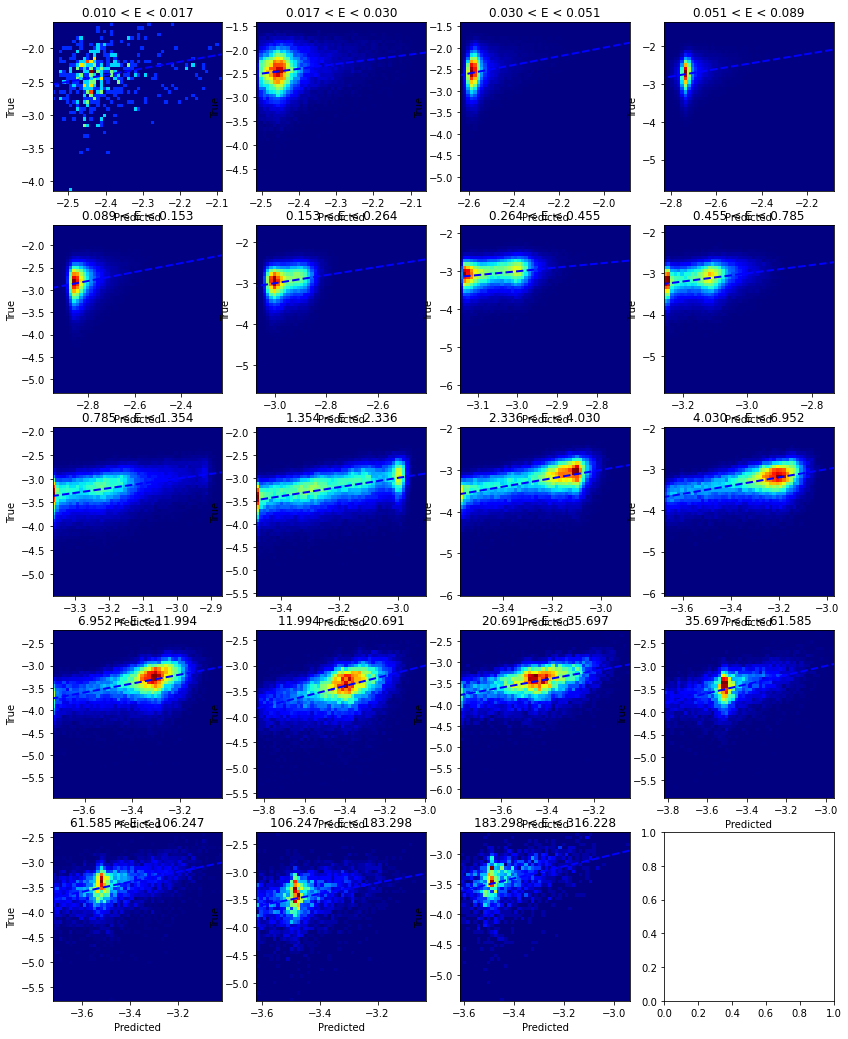

In [47]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 18])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)
rf_scores = []
for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
    dtree_model = SVR(C=1.0, epsilon=0.2).fit(X_train, y_train) 
    y_pred = dtree_model.predict(X_test) 
    # Big bins
    ax.hist2d(y_pred, y_test, bins=(50, 50), range=[[-6, -2], [-6,-2]], cmap=plt.cm.jet)
#     ax.scatter(y_pred, y_test, lw=2, alpha=0.3, label='')
    ax.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)],
             linestyle='--', lw=2, color='blue')
    ax.set_title("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    score = round(dtree_model.score(X_test, y_test), 4)
    print("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    rf_scores.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
plt.show()
result_scores['SVR_1_0.2'] = rf_scores.copy()

0.0 0
0.010 < E < 0.017
Root Mean Squared Error: 0.34620557979573
0.0 1
0.017 < E < 0.030
Root Mean Squared Error: 0.34481942854879705
0.0 2
0.030 < E < 0.051
Root Mean Squared Error: 0.33977754496684864
0.0 3
0.051 < E < 0.089
Root Mean Squared Error: 0.3232680132124363
1.0 0
0.089 < E < 0.153
Root Mean Squared Error: 0.3146402193777165
1.0 1
0.153 < E < 0.264
Root Mean Squared Error: 0.3068704502144271
1.0 2
0.264 < E < 0.455
Root Mean Squared Error: 0.3021003839791378
1.0 3
0.455 < E < 0.785
Root Mean Squared Error: 0.2998936237729967
2.0 0
0.785 < E < 1.354
Root Mean Squared Error: 0.2948823310537193
2.0 1
1.354 < E < 2.336
Root Mean Squared Error: 0.29665923711226433
2.0 2
2.336 < E < 4.030
Root Mean Squared Error: 0.2956556947750169
2.0 3
4.030 < E < 6.952
Root Mean Squared Error: 0.2941422448459674
3.0 0
6.952 < E < 11.994
Root Mean Squared Error: 0.294155818263297
3.0 1
11.994 < E < 20.691
Root Mean Squared Error: 0.29510500032094955
3.0 2
20.691 < E < 35.697
Root Mean Squared 

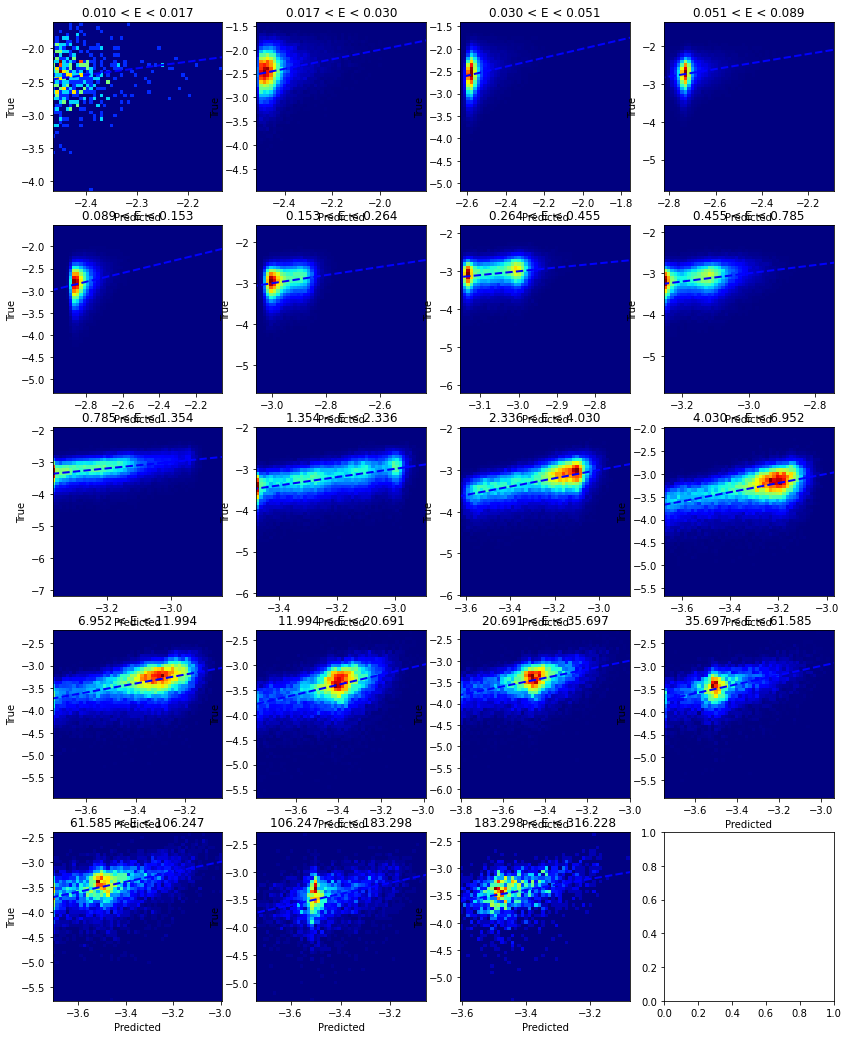

In [55]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 18])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)
rf_scores = []
for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
    dtree_model = SVR(C=1.0, epsilon=0.2).fit(X_train, y_train) 
    y_pred = dtree_model.predict(X_test) 
    # Big bins
    ax.hist2d(y_pred, y_test, bins=(50, 50), range=[[-6, -2], [-6,-2]], cmap=plt.cm.jet)
#     ax.scatter(y_pred, y_test, lw=2, alpha=0.3, label='')
    ax.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)],
             linestyle='--', lw=2, color='blue')
    ax.set_title("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    score = round(dtree_model.score(X_test, y_test), 4)
    print("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    rf_scores.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
plt.show()
result_scores['SVR_1_0.2'] = rf_scores.copy()

0.0 0
0.010 < E < 0.017
Root Mean Squared Error: 0.3689892685507613
0.0 1
0.017 < E < 0.030
Root Mean Squared Error: 0.34387605884055633
0.0 2
0.030 < E < 0.051
Root Mean Squared Error: 0.3341503217957723
0.0 3
0.051 < E < 0.089
Root Mean Squared Error: 0.3190707094460536
1.0 0
0.089 < E < 0.153
Root Mean Squared Error: 0.31103716171590773
1.0 1
0.153 < E < 0.264
Root Mean Squared Error: 0.30524783255202187
1.0 2
0.264 < E < 0.455
Root Mean Squared Error: 0.30197423591586137
1.0 3
0.455 < E < 0.785
Root Mean Squared Error: 0.29971886441646384
2.0 0
0.785 < E < 1.354
Root Mean Squared Error: 0.29526373149377344
2.0 1
1.354 < E < 2.336
Root Mean Squared Error: 0.29629122313881984
2.0 2
2.336 < E < 4.030
Root Mean Squared Error: 0.2958775061904989
2.0 3
4.030 < E < 6.952
Root Mean Squared Error: 0.29440475142021927
3.0 0
6.952 < E < 11.994
Root Mean Squared Error: 0.2947216835005045
3.0 1
11.994 < E < 20.691
Root Mean Squared Error: 0.296460992000236
3.0 2
20.691 < E < 35.697
Root Mean Sq

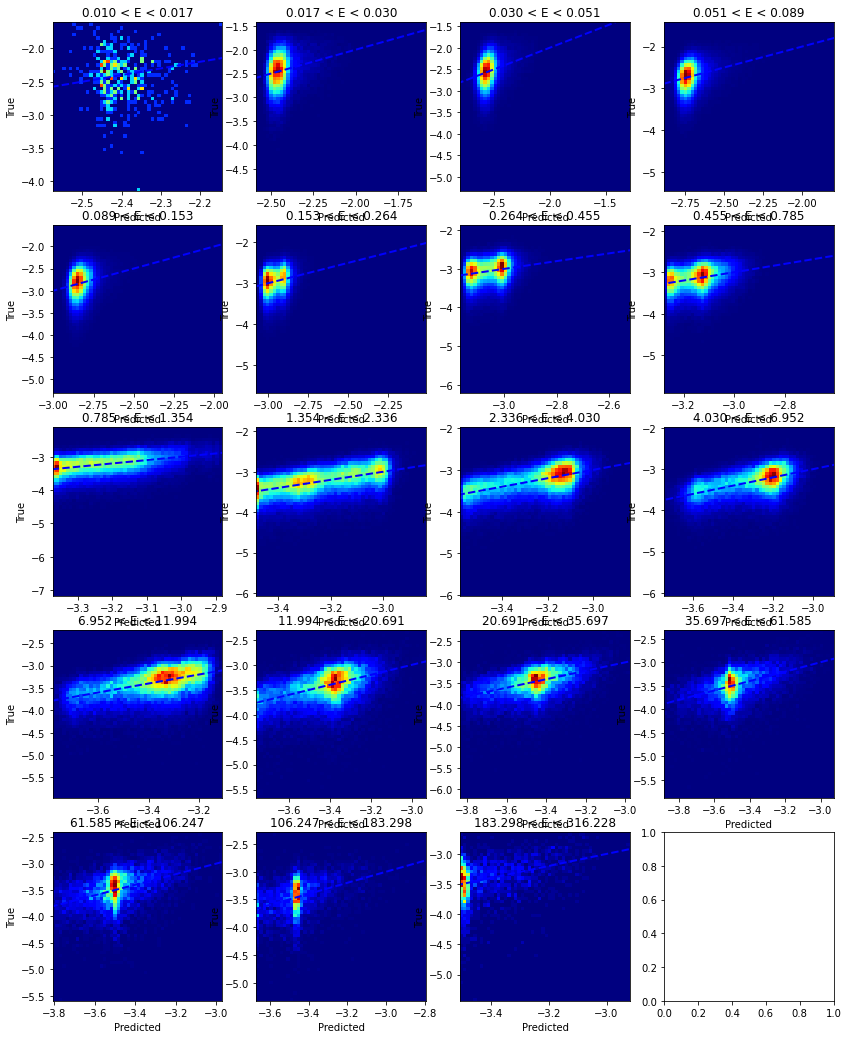

In [56]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 18])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)
rf_scores = []
for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
    dtree_model = SVR(C=10.0, epsilon=0.2).fit(X_train, y_train) 
    y_pred = dtree_model.predict(X_test) 
    # Big bins
    ax.hist2d(y_pred, y_test, bins=(50, 50), range=[[-6, -2], [-6,-2]], cmap=plt.cm.jet)
#     ax.scatter(y_pred, y_test, lw=2, alpha=0.3, label='')
    ax.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)],
             linestyle='--', lw=2, color='blue')
    ax.set_title("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    score = round(dtree_model.score(X_test, y_test), 4)
    print("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    rf_scores.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
plt.show()
result_scores['SVR_10_0.2'] = rf_scores.copy()

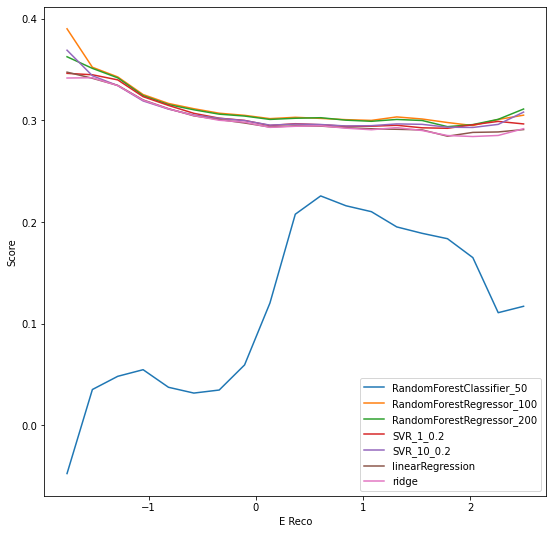

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 9])
log_e_reco_bins = np.linspace(-2., 2.5, 20)
for key in result_scores.keys():
    ax.plot(log_e_reco_bins[1:], result_scores[key], label=key)

plt.ylabel('Score')
plt.xlabel('E Reco')
plt.legend()
plt.show()


0.0 0
0.010 < E < 0.017
Root Mean Squared Error: 0.3474045766053909
0.0 1
0.017 < E < 0.030
Root Mean Squared Error: 0.3413603122300114
0.0 2
0.030 < E < 0.051
Root Mean Squared Error: 0.3343563407392638
0.0 3
0.051 < E < 0.089
Root Mean Squared Error: 0.3200506046160519
1.0 0
0.089 < E < 0.153
Root Mean Squared Error: 0.31144993057833104
1.0 1
0.153 < E < 0.264
Root Mean Squared Error: 0.3044013674725855
1.0 2
0.264 < E < 0.455
Root Mean Squared Error: 0.30078771106140473
1.0 3
0.455 < E < 0.785
Root Mean Squared Error: 0.29736277418945883
2.0 0
0.785 < E < 1.354
Root Mean Squared Error: 0.29341802221806823
2.0 1
1.354 < E < 2.336
Root Mean Squared Error: 0.29453036786992604
2.0 2
2.336 < E < 4.030
Root Mean Squared Error: 0.29428218983892207
2.0 3
4.030 < E < 6.952
Root Mean Squared Error: 0.2927581143463072
3.0 0
6.952 < E < 11.994
Root Mean Squared Error: 0.29167671753572516
3.0 1
11.994 < E < 20.691
Root Mean Squared Error: 0.2911714598602612
3.0 2
20.691 < E < 35.697
Root Mean Sq

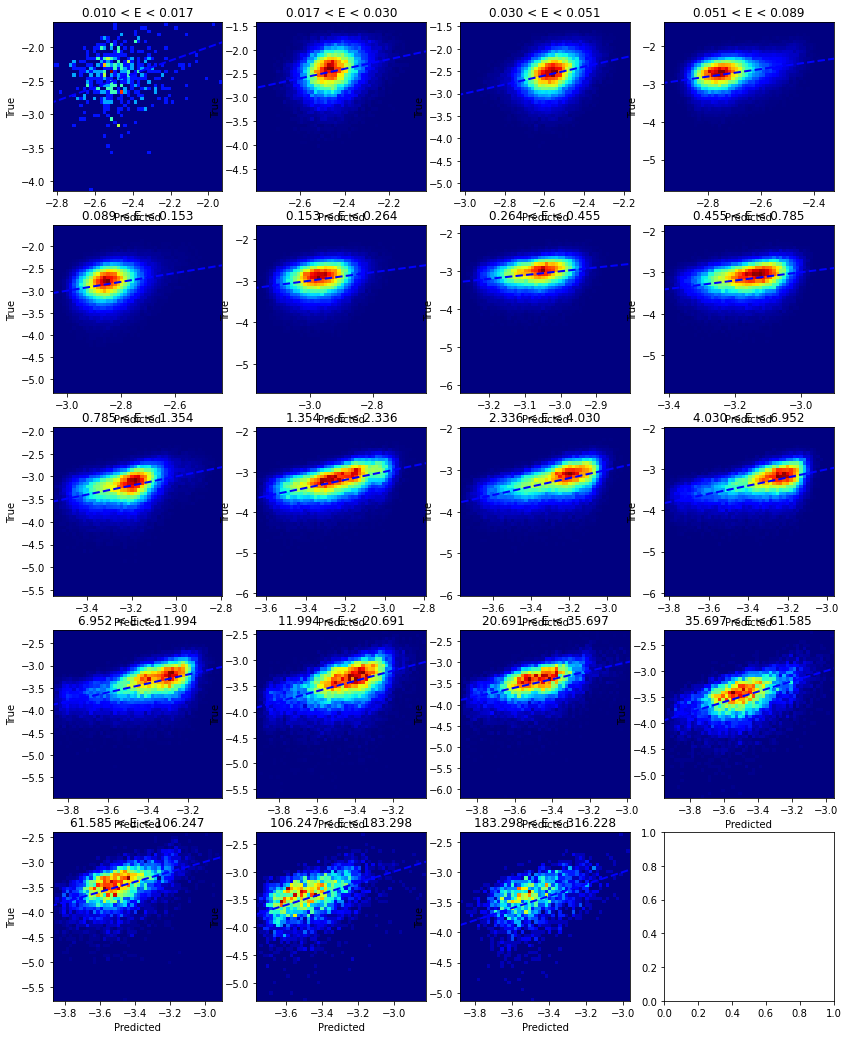

In [54]:
from sklearn.linear_model import LinearRegression
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 18])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)
rf_scores = []
for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
    dtree_model = LinearRegression(n_jobs=4).fit(X_train, y_train) 
    y_pred = dtree_model.predict(X_test) 
    # Big bins
    ax.hist2d(y_pred, y_test, bins=(50, 50), range=[[-6, -2], [-6,-2]], cmap=plt.cm.jet)
#     ax.scatter(y_pred, y_test, lw=2, alpha=0.3, label='')
    ax.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)],
             linestyle='--', lw=2, color='blue')
    ax.set_title("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    score = round(dtree_model.score(X_test, y_test), 4)
    print("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    rf_scores.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
plt.show()
result_scores['linearRegression'] = rf_scores.copy()

0.0 0
0.010 < E < 0.017
Root Mean Squared Error: 0.34162503089824114
0.0 1
0.017 < E < 0.030
Root Mean Squared Error: 0.3418859705455103
0.0 2
0.030 < E < 0.051
Root Mean Squared Error: 0.33416286672197804
0.0 3
0.051 < E < 0.089
Root Mean Squared Error: 0.31973215897688495
1.0 0
0.089 < E < 0.153
Root Mean Squared Error: 0.3112608039303097
1.0 1
0.153 < E < 0.264
Root Mean Squared Error: 0.30466447345271686
1.0 2
0.264 < E < 0.455
Root Mean Squared Error: 0.30005491361803294
1.0 3
0.455 < E < 0.785
Root Mean Squared Error: 0.2981693838625243
2.0 0
0.785 < E < 1.354
Root Mean Squared Error: 0.29306178472116007
2.0 1
1.354 < E < 2.336
Root Mean Squared Error: 0.29413742245329266
2.0 2
2.336 < E < 4.030
Root Mean Squared Error: 0.29462297936467935
2.0 3
4.030 < E < 6.952
Root Mean Squared Error: 0.2922580878895653
3.0 0
6.952 < E < 11.994
Root Mean Squared Error: 0.2907154911706382
3.0 1
11.994 < E < 20.691
Root Mean Squared Error: 0.29282775025726454
3.0 2
20.691 < E < 35.697
Root Mean 

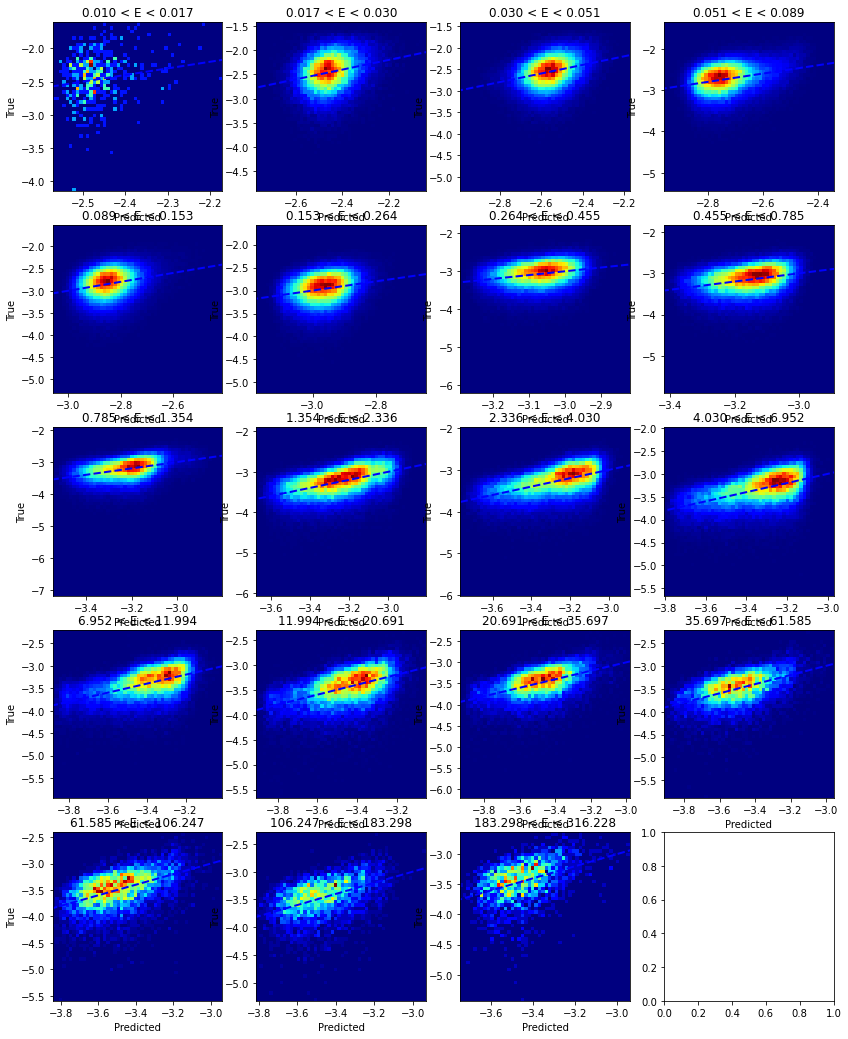

In [57]:
from sklearn.linear_model import Ridge
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 18])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)
rf_scores = []
for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
    dtree_model = Ridge(alpha=1.0).fit(X_train, y_train) 
    y_pred = dtree_model.predict(X_test) 
    # Big bins
    ax.hist2d(y_pred, y_test, bins=(50, 50), range=[[-6, -2], [-6,-2]], cmap=plt.cm.jet)
#     ax.scatter(y_pred, y_test, lw=2, alpha=0.3, label='')
    ax.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)],
             linestyle='--', lw=2, color='blue')
    ax.set_title("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    score = round(dtree_model.score(X_test, y_test), 4)
    print("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    rf_scores.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
plt.show()
result_scores['ridge'] = rf_scores.copy()

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 18])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)
rf_scores = []
for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
    kernel = DotProduct() + WhiteKernel()
    dtree_model = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train, y_train) 
    y_pred = dtree_model.predict(X_test) 
    # Big bins
    ax.hist2d(y_pred, y_test, bins=(50, 50), range=[[-6, -2], [-6,-2]], cmap=plt.cm.jet)
#     ax.scatter(y_pred, y_test, lw=2, alpha=0.3, label='')
    ax.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)],
             linestyle='--', lw=2, color='blue')
    ax.set_title("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    score = round(dtree_model.score(X_test, y_test), 4)
    print("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    rf_scores.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
plt.show()
result_scores['GaussianProcessRegressor'] = rf_scores.copy()

0.0 0
0.010 < E < 0.017
Root Mean Squared Error: 0.3428267984681116
0.0 1
0.017 < E < 0.030
Root Mean Squared Error: 0.3421937720760222
0.0 2


In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[14, 18])
# Plot
log_e_reco_bins = np.linspace(-2., 2.5, 20)
rf_scores = []
for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue

    mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                          dtf['log_reco_energy'] < log_e_high)
    this_dtf = dtf[mask]
    if not len(this_dtf) > 0:
        continue
        
    print(np.floor((i-1)/4)%5, (i-1)%4)
    ax = axs[int(np.floor((i-1)/4)%5), (i-1)%4]
    
    dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

    X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
               'img2_ang', 'log_SizeSecondMax']
    X_train = dtf_train[X_names].values
    y_train = dtf_train[train_feature].values
    X_test = dtf_test[X_names].values
    y_test = dtf_test[train_feature].values

    # dividing X, y into train and test data 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

    # training a DescisionTreeClassifier 
    kernel = DotProduct() + WhiteKernel()
    dtree_model = linear_model.Lasso(alpha=0.1).fit(X_train, y_train) 
    y_pred = dtree_model.predict(X_test) 
    # Big bins
    ax.hist2d(y_pred, y_test, bins=(50, 50), range=[[-6, -2], [-6,-2]], cmap=plt.cm.jet)
#     ax.scatter(y_pred, y_test, lw=2, alpha=0.3, label='')
    ax.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)],
             linestyle='--', lw=2, color='blue')
    ax.set_title("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    score = round(dtree_model.score(X_test, y_test), 4)
    print("{:3.3f} < E < {:3.3f}".format(10**log_e_reco_bins[i-1], 10**log_e_high))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    rf_scores.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
plt.show()
result_scores['Lasso_0.1'] = rf_scores.copy()

In [40]:
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000).fit(X_tr, y_tr)
LR.predict(X_test)
print(round(LR.score(X_test,y_test), 4))

RF = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, n_jobs=4).fit(X_tr, y_tr)
RF.predict(X_test)
print(round(RF.score(X_test, y_test), 4))

NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), 
                   random_state=1,max_iter=10000).fit(X_tr, y_tr)
NN.predict(X_test)
print(round(NN.score(X_test, y_test), 4))

0.3308
0.3431
0.2498


In [41]:
RF = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, 
                            random_state=0, n_jobs=4).fit(X_tr, y_tr)
RF.predict(X_test)
print(round(RF.score(X_test, y_test), 4))

0.3174


In [ ]:
GBC = GradientBoostingClassifier(n_estimators=100, max_depth=10, 
                                 learning_rate=1.0, verbose=True).fit(X_tr, y_tr)
GBC.predict(X_test)
print(round(GBC.score(X_test, y_test), 4))

      Iter       Train Loss   Remaining Time 
         1     1226203.6706           43.71m
         2     1215735.4039           46.91m
         3     1210936.7471           49.85m
         4     1208279.0064           48.37m
         5     1205623.6623           47.30m
         6     1202936.1571           46.41m
         7     1200125.4149           45.21m


In [14]:
LR2 = LogisticRegression(solver='liblinear', multi_class='ovr').fit(X_tr, y_tr)
LR2.predict(X_test)
print(round(LR2.score(X_test, y_test), 4))

LDA = LinearDiscriminantAnalysis().fit(X_tr, y_tr)
LDA.predict(X_test)
print(round(LDA.score(X_test, y_test), 4))

KNC = KNeighborsClassifier().fit(X_tr, y_tr)
KNC.predict(X_test)
print(round(KNC.score(X_test, y_test), 4))

DTC = DecisionTreeClassifier().fit(X_tr, y_tr)
DTC.predict(X_test)
print(round(DTC.score(X_test, y_test), 4))

GNB = GaussianNB().fit(X_tr, y_tr)
GNB.predict(X_test)
print(round(GNB.score(X_test, y_test), 4))

0.2957
0.2961
0.2616
0.271
0.2705


In [15]:
bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1).fit(X_tr, y_tr)
bdt_real.predict(X_test)
print(round(bdt_real.score(X_test, y_test), 4))

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME").fit(X_tr, y_tr)
bdt_discrete.predict(X_test)
print(round(bdt_discrete.score(X_test, y_test), 4))

0.3019
0.3015


This one takes fucking ages to train...

In [ ]:
SVML = svm.SVC(kernel="linear", cache_size=7000, verbose=True).fit(X_tr, y_tr)
SVML.predict(X_test)
print(round(SVML.score(X_test, y_test), 4))

In [ ]:
SVM = svm.SVC(decision_function_shape="ovo", cache_size=7000, verbose=True).fit(X_tr, y_tr)
SVM.predict(X_test)
print(round(SVM.score(X_test, y_test), 4))

In [17]:
mask = np.logical_and(dtf['log_reco_energy'] > 0.5, 
                      dtf['log_reco_energy'] < 0.7)
this_dtf = dtf[mask]
len(this_dtf)

103988

In [7]:
for n_estimators in [100, 200, 300]:
    log_e_reco_bins = np.linspace(-2., 2.5, 20)
    rf_scores = []
    for i, log_e_high in enumerate(log_e_reco_bins):
        if i is 0:
            continue

        mask = np.logical_and(dtf['log_reco_energy'] > log_e_reco_bins[i-1], 
                              dtf['log_reco_energy'] < log_e_high)
        this_dtf = dtf[mask]
        if not len(this_dtf) > 0:
            continue

        print(np.floor((i-1)/4)%5, (i-1)%4)

        dtf_train, dtf_test = model_selection.train_test_split(this_dtf, test_size=0.85)## print info

        X_names = ['log_reco_energy', 'log_NTels_reco', 'array_distance', 
                   'img2_ang', 'log_SizeSecondMax']
        X_train = dtf_train[X_names].values
        y_train = dtf_train[train_feature].values
        X_test = dtf_test[X_names].values
        y_test = dtf_test[train_feature].values

        # dividing X, y into train and test data 
        # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

        # training a DescisionTreeClassifier 
        dtree_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=None, min_samples_split=2, random_state=0, 
                                             n_jobs=4).fit(X_train, y_train) 
        dtree_predictions = dtree_model.predict(X_test) 
        score = round(dtree_model.score(X_test, y_test), 4)
        print("{:3.3f} < E < {:3.3f} -- Score: {}".format(10**log_e_reco_bins[i-1],
                                                          10**log_e_high,
                                                          score))
        rf_scores.append(score)

    result_scores['RandomForestClassifier_{}'.format(n_estimators)] = rf_scores.copy()

0.0 0
0.010 < E < 0.017 -- Score: 0.2689
0.0 1
0.017 < E < 0.030 -- Score: 0.2835
0.0 2
0.030 < E < 0.051 -- Score: 0.2972
0.0 3
0.051 < E < 0.089 -- Score: 0.2976
1.0 0
0.089 < E < 0.153 -- Score: 0.2876
1.0 1
0.153 < E < 0.264 -- Score: 0.2845
1.0 2
0.264 < E < 0.455 -- Score: 0.2861
1.0 3
0.455 < E < 0.785 -- Score: 0.3039
2.0 0
0.785 < E < 1.354 -- Score: 0.3295
2.0 1
1.354 < E < 2.336 -- Score: 0.3705
2.0 2
2.336 < E < 4.030 -- Score: 0.3766
2.0 3
4.030 < E < 6.952 -- Score: 0.3643
3.0 0
6.952 < E < 11.994 -- Score: 0.3618
3.0 1
11.994 < E < 20.691 -- Score: 0.3574
3.0 2
20.691 < E < 35.697 -- Score: 0.3694
3.0 3
35.697 < E < 61.585 -- Score: 0.3578
4.0 0
61.585 < E < 106.247 -- Score: 0.3585
4.0 1
106.247 < E < 183.298 -- Score: 0.3465
4.0 2
183.298 < E < 316.228 -- Score: 0.3253
0.0 0
0.010 < E < 0.017 -- Score: 0.2836
0.0 1
0.017 < E < 0.030 -- Score: 0.2862
0.0 2
0.030 < E < 0.051 -- Score: 0.296
0.0 3
0.051 < E < 0.089 -- Score: 0.2949
1.0 0
0.089 < E < 0.153 -- Score: 0.2883

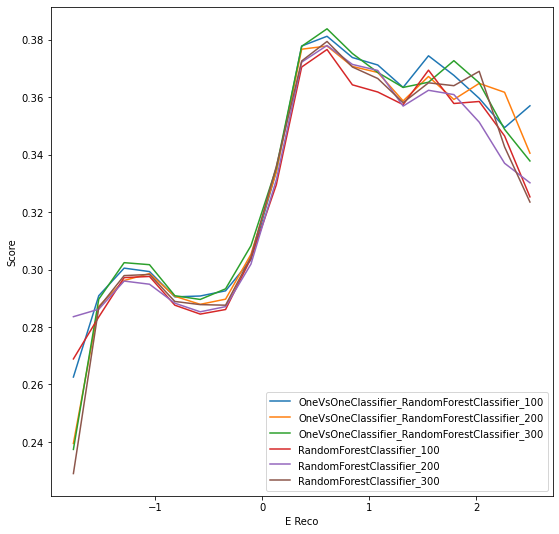

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 9])
log_e_reco_bins = np.linspace(-2., 2.5, 20)
for key in result_scores.keys():
    ax.plot(log_e_reco_bins[1:], result_scores[key], label=key)

plt.ylabel('Score')
plt.xlabel('E Reco')
plt.legend()
plt.show()


In [13]:
result_scores.keys()

dict_keys(['RandomForestClassifier_50', 'OneVsRestClassifier_RandomForestClassifier_50', 'OneVsOneClassifier_RandomForestClassifier_50'])

In [19]:
# gamma_file = uproot.open("gamma_cone.S.3HB9-FD_ID0.eff-0.root")
gamma_file = uproot.open("gamma_onSource.S.3HB9-FD_ID0.eff-0.root")
# proton_file = uproot.open("proton_onSource.S.3HB9-FD_ID0.eff-0.root")

In [20]:
gamma_file.keys()

[b'fEffArea;1',
 b'hEmc;2',
 b'hEmc;1',
 b'fEventTreeCuts;1',
 b'data;1',
 b't_angular_resolution;1',
 b't_angular_resolution_080p;1',
 b't_angular_resolution_095p;1',
 b't_core_resolution;1',
 b't_energy_resolution;1',
 b'GammaHadronCutsStats;1',
 b'TMVAEvaluatorResults;1',
 b'GammaHadronCuts;1',
 b'MC_runheader;1',
 b'makeEffectiveArea_runparameter;1']

In [21]:
data = gamma_file["data"]

In [23]:
data.keys()

[b'runNumber',
 b'eventNumber',
 b'MJD',
 b'Time',
 b'TelElevation',
 b'TelAzimuth',
 b'ArrayPointing_Elevation',
 b'ArrayPointing_Azimuth',
 b'WobbleN',
 b'WobbleE',
 b'LTrig',
 b'NTrig',
 b'NImages',
 b'ImgSel',
 b'MCprimary',
 b'MCe0',
 b'MCxcore',
 b'MCycore',
 b'MCaz',
 b'MCze',
 b'MCxoff',
 b'MCyoff',
 b'MCCorsikaRunID',
 b'MCCorsikaShowerID',
 b'MCFirstInteractionHeight',
 b'MCFirstInteractionDepth',
 b'MCR',
 b'ImgSel_list',
 b'NTtype',
 b'TtypeID',
 b'NImages_Ttype',
 b'img2_ang',
 b'RecID',
 b'Ze',
 b'Az',
 b'Xoff',
 b'Yoff',
 b'Xoff_derot',
 b'Yoff_derot',
 b'stdS',
 b'Xcore',
 b'Ycore',
 b'stdP',
 b'Chi2',
 b'meanPedvar_Image',
 b'ntubes',
 b'dist',
 b'fui',
 b'size',
 b'loss',
 b'width',
 b'length',
 b'tgrad_x',
 b'DispNImages',
 b'DispXoff_T',
 b'DispYoff_T',
 b'DispWoff_T',
 b'DispDiff',
 b'Xoff_intersect',
 b'Yoff_intersect',
 b'cross',
 b'crossO',
 b'R',
 b'NMSCW',
 b'ES',
 b'MSCW',
 b'MSCL',
 b'MWR',
 b'MLR',
 b'ErecS',
 b'EChi2S',
 b'dES',
 b'dESabs',
 b'NErecST',
 b

In [56]:
cross = data.array('dES')[gamma_like_events]
cross

array([0.15750434, 0.07138596, 0.07593285, ..., 0.16507931, 0.19460683,
       0.12524788])

In [57]:
crossO = data.array('dESabs')[gamma_like_events]
crossO

array([0.00577715, 0.63479972, 0.65982693, ..., 0.28019682, 0.71403992,
       0.01918565])

In [24]:
cuts = gamma_file["fEventTreeCuts"]

# Cut 1: Events surviving gamma/hadron separation and direction cuts:
mask_gamma_like_and_direction = cuts.array('CutClass') == 5

# Cut 2: Events surviving gamma/hadron separation cut and not direction cut:
mask_gamma_like_no_direction = cuts.array('CutClass') == 0

gamma_like_events = np.logical_or(mask_gamma_like_and_direction, mask_gamma_like_no_direction)

In [25]:
# Definition of TtypeID within eventDisplay:
all_ttypes = {138704810: 'LST',
              10408618: 'MST-FlashCam',
              10408418: 'MST-NectarCam',
              201511619: 'SST-ASTRI',
              201309316: 'SST-GC',
              909924: 'SST-DC',
              207308707: 'MST-SC'}
# Identify the telescope types within the 'NImages_Ttype' array:
tel_types = [all_ttypes[t] for t in data.array("TtypeID")[0]]
print('File containing the following telescope types: {}'.format(tel_types))
for i, tel in enumerate(tel_types):
    # TODO: Note if some MSTs are of one type and some other MSTs of another, this will not work.
    # TODO: The solution is perhaps to store as NTels_reco[all_telescope_types], or more simply
    # TODO: a dictionary.
    if 'LST' in tel:
        NTels_reco_lst = [images_type[i] for images_type in data.array("NImages_Ttype")[gamma_like_events]]
    if 'MST' in tel:
        NTels_reco_mst = [images_type[i] for images_type in data.array("NImages_Ttype")[gamma_like_events]]
    if 'SST' in tel:
        NTels_reco_sst = [images_type[i] for images_type in data.array("NImages_Ttype")[gamma_like_events]]


File containing the following telescope types: ['SST-DC', 'MST-FlashCam', 'LST']


In [59]:
mc_energy = data.array("MCe0")[gamma_like_events]  # mc_energy = tb.Float32Col(dflt=np.nan, pos=7)

# Variables for regression:
mc_alt = 90 - data.array("MCze")[gamma_like_events]
mc_az = data.array("MCaz")[gamma_like_events]
reco_alt = 90 - data.array("Ze")[gamma_like_events]  # reco_alt = tb.Float32Col(dflt=np.nan, pos=9)
reco_az = data.array("Az")[gamma_like_events]  # reco_az = tb.Float32Col(dflt=np.nan, pos=10)
# Angular separation bewteen the true vs reconstructed direction
ang_diff = angular_separation(
    mc_az * u.deg,  # az
    mc_alt * u.deg,  # alt
    reco_az * u.deg,
    reco_alt * u.deg,
)


# Variables for training:
av_size = [np.average(sizes) for sizes in data.array("size")[gamma_like_events]]       
reco_energy = data.array("ErecS")[gamma_like_events]  
NTels_reco = data.array("NImages")[gamma_like_events]
x_cores = data.array('Xcore')[gamma_like_events]
y_cores = data.array('Ycore')[gamma_like_events]
array_distance = np.sqrt(x_cores**2. + y_cores**2.)
x_off = data.array('Xoff')[gamma_like_events]
y_off = data.array('Yoff')[gamma_like_events]
camera_offset = np.sqrt(x_off**2. + y_off**2.)
img2_ang = data.array('img2_ang')[gamma_like_events]
EChi2S = data.array('EChi2S')[gamma_like_events]
SizeSecondMax = data.array('SizeSecondMax')[gamma_like_events]
NTelPairs = data.array('NTelPairs')[gamma_like_events]
MSCW = data.array('MSCW')[gamma_like_events]
MSCL = data.array('MSCL')[gamma_like_events]
EmissionHeight = data.array('EmissionHeight')[gamma_like_events]
EmissionHeightChi2 = data.array('EmissionHeightChi2')[gamma_like_events]
dist = data.array('dist')[gamma_like_events]
av_dist = [np.average(dists) for dists in dist]     
DispDiff = data.array('DispDiff')[gamma_like_events]
dESabs = data.array('dESabs')[gamma_like_events]


In [60]:
# Bin in reconstructed energy, and calculate percentiles (in this case 4 event types):
event_types = np.zeros_like(reco_energy)
log_e_reco_bins = np.linspace(-2., 2.5, 40)
for i, log_e_high in enumerate(log_e_reco_bins):
    if i is 0:
        continue
    e_low = 10**log_e_reco_bins[i-1]
    e_high = 10**log_e_high
    # Select events within the rec. energy bin:
    events = np.logical_and(reco_energy > e_low, reco_energy < e_high)
    # Make sure there are events:
    if not np.sum(events) > 0:
        continue
    p1 = np.percentile(ang_diff[events], 25)
    p2 = np.percentile(ang_diff[events], 50)
    p3 = np.percentile(ang_diff[events], 75)
    event_types[np.logical_and(events, ang_diff < p1)] = 1
    event_types[np.logical_and(np.logical_and(events, ang_diff >= p1), ang_diff < p2)] = 2
    event_types[np.logical_and(np.logical_and(events, ang_diff >= p2), ang_diff < p3)] = 3
    event_types[np.logical_and(events, ang_diff >= p3)] = 4

In [64]:
# Build astropy table:
t = Table()
t['log_ang_diff'] = np.log10(ang_diff.value)
# t['log_av_size'] = np.log10(av_size)
t['log_reco_energy'] = np.log10(reco_energy)
t['log_NTels_reco'] = np.log10(NTels_reco)
t['array_distance'] = array_distance
t['img2_ang'] = img2_ang
# t['log_EChi2S'] = np.log10(EChi2S)
t['log_SizeSecondMax'] = np.log10(SizeSecondMax)
# t['log_NTelPairs'] = np.log10(NTelPairs)
# t['MSCW'] = MSCW
# t['MSCL'] = MSCL
# t['camera_offset'] = camera_offset
t['log_EmissionHeight'] = np.log10(EmissionHeight)
t['log_EmissionHeightChi2'] = np.log10(EmissionHeightChi2)
t['event_types'] = event_types
t['av_dist'] = av_dist
t['log_DispDiff'] = np.log10(DispDiff)
t['log_EChi2S'] = np.log10(EChi2S)
t['log_dESabs'] = np.log10(dESabs)
t['log_EmissionHeight'] = np.log10(EmissionHeight)
t['log_EmissionHeightChi2'] = np.log10(EmissionHeightChi2)

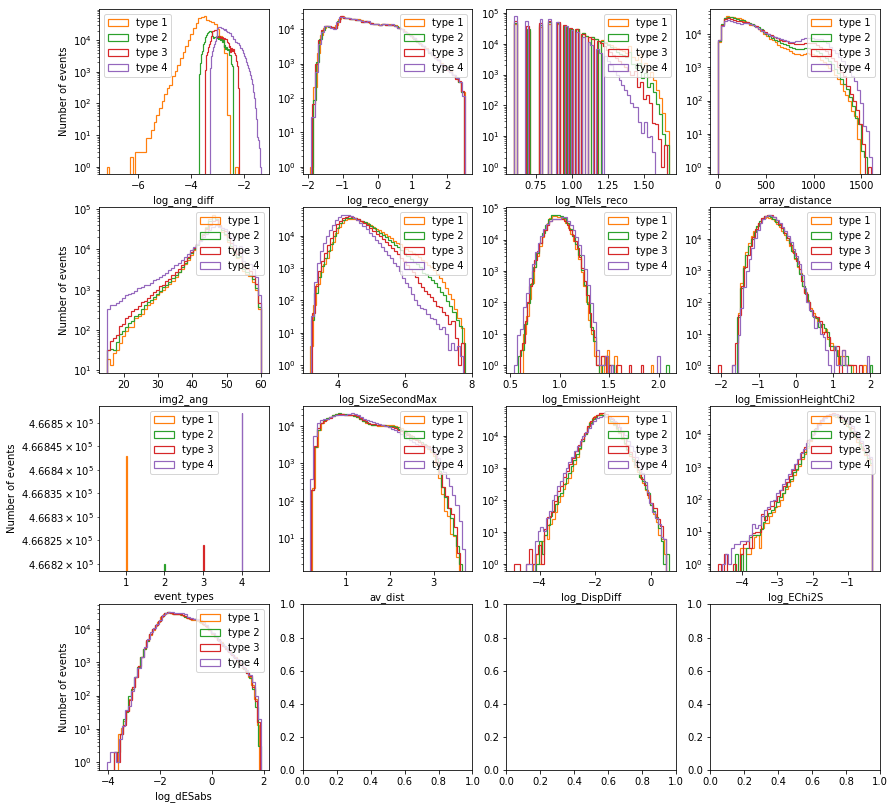

In [65]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=[14, 14])
# Plot
for i, colname in enumerate(t.colnames):
    ax = axs[int(np.floor(i/4)%4), i%4]
    for event_type in [1,2,3,4]:
        mask = t['event_types']==event_type
        this_table = t[mask]
        n, bins, patches = ax.hist(this_table[colname], 50, histtype='step', density=False, alpha=1.0, 
                                   edgecolor="C{}".format(event_type), linewidth=1.2, 
                                   label="type {}".format(event_type))
    ax.legend()
    ax.set_xlabel(colname)
    if i%4 is 0:
        ax.set_ylabel('Number of events')
#     ax.set_xscale('log')
    ax.set_yscale('log')
plt.show()

In [26]:
dtf = t.to_pandas()

In [27]:
'''
Recognize whether a column is numerical or categorical.
'''
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

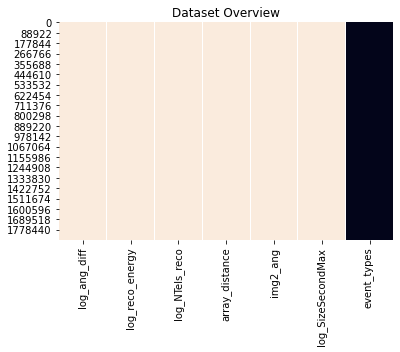

 Categerocial   Numeric   NaN 


In [29]:
max_cat=20
dic_cols = {col:utils_recognize_type(dtf, col, max_cat=max_cat) for col in dtf.columns}
heatmap = dtf.isnull()
for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)

sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [ ]:
# compare algorithms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# Load dataset
dataset = t.to_pandas()
# Split-out validation dataset
array = dataset.values
# We remove the ang_diff, and leave the event type as Y:
X = array[:,1:6]
y = array[:,6]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.60, random_state=1, 
                                                                shuffle=True)
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


LR: 0.331806 (0.000733)


/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


LDA: 0.332654 (0.001151)


/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


KNN: 0.291510 (0.001480)


/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


CART: 0.285828 (0.001951)


/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


NB: 0.331059 (0.001328)


/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, 
                                                                                 df.index, test_size=0.33, 
                                                                                 random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
## for machine learning



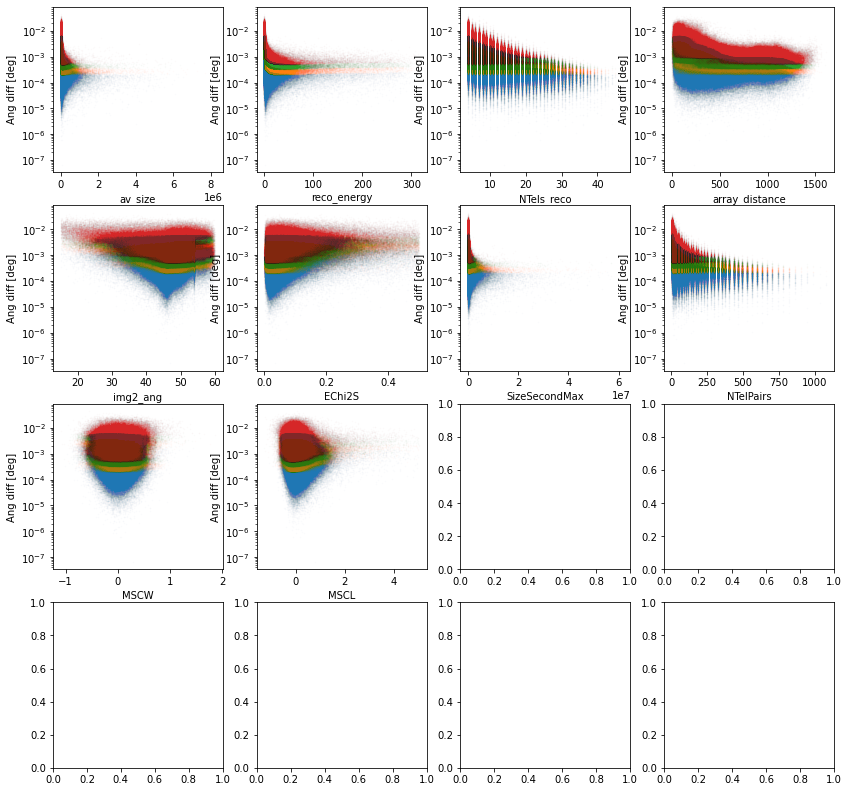

In [145]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=[14, 14])
# Plot
for i, colname in enumerate(t.colnames[1:-1]):
    ax = axs[int(np.floor(i/4)%4), i%4]
    for event_type in [1,2,3,4]:
        mask = t['event_types']==event_type
        this_table = t[mask]
        ax.scatter(this_table[colname], this_table['ang_diff'], alpha=0.01, 
                    s=1, label="type {}".format(event_type))
#     ax.legend()
    ax.set_xlabel(colname)
    ax.set_ylabel('Ang diff [deg]')
#     ax.set_xscale('log')
    ax.set_yscale('log')
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=[14, 7])
# Plot
for event_type in [1,2,3,4]:
    mask = t['event_types']==event_type
    this_table = t[mask]
    axs.scatter(this_table['reco_energy'], this_table['ang_diff'], alpha=0.1, 
                s=1, label="type {}".format(event_type))
axs.set_xlabel('Rec Energy')
axs.set_ylabel('Ang diff [deg]')
axs.set_xscale('log')
axs.set_yscale('log')
plt.show()

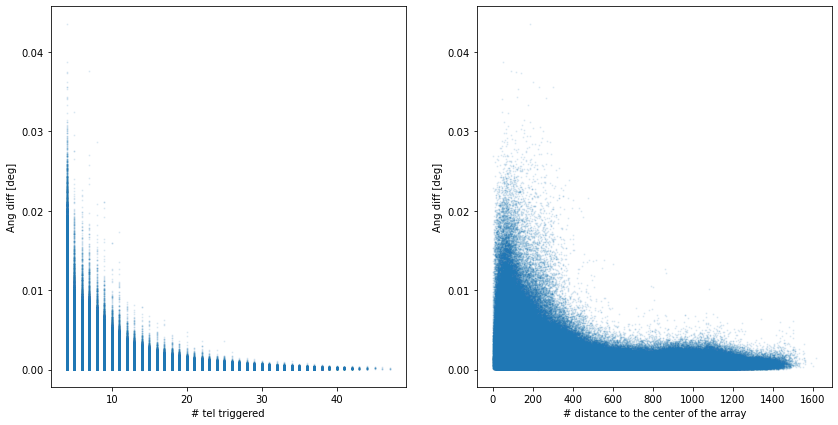

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[14, 7])

# Plot
for t in [1,2,3,4]:
    
    axs[0].scatter(NTels_reco, ang_diff, alpha=0.1, s=1)
    axs[0].set_xlabel('# tel triggered')
    axs[0].set_ylabel('Ang diff [deg]')

    axs[1].scatter(array_distance, ang_diff, alpha=0.1, s=1)
    axs[1].set_xlabel('# distance to the center of the array')
    axs[1].set_ylabel('Ang diff [deg]')
#     ax.title('X/Y cores')
#     ax.xlabel('x')
#     ax.ylabel('y')
plt.show()

In [4]:
mc_energy_hist = gamma_file['hEmc;1']

In [5]:
bin_content, bin_edges = mc_energy_hist.numpy()

In [6]:
bin_content

array([2.11031867e+10, 1.49394752e+10, 1.05759676e+10, 7.48743384e+09,
       5.30155606e+09, 3.75365415e+09, 2.65683326e+09, 1.88066457e+09,
       1.33185122e+09, 9.41965251e+08, 6.66276741e+08, 4.71858251e+08,
       3.34548871e+08, 2.36298561e+08, 1.67836516e+08, 1.18509122e+08,
       8.39464579e+07, 5.94984041e+07, 4.21071190e+07, 2.97400456e+07,
       2.10623637e+07, 1.49444227e+07, 1.06564244e+07, 7.48342503e+06,
       5.25758440e+06, 3.73173060e+06, 2.65654994e+06, 1.88628108e+06,
       1.33210701e+06, 9.47258567e+05, 6.71102389e+05, 4.71099852e+05,
       3.34479902e+05, 2.36881796e+05, 1.67564369e+05, 1.14381887e+05,
       8.16580160e+04, 6.04423794e+04, 4.09352990e+04, 3.02078612e+04,
       2.10438660e+04, 1.51731999e+04, 9.71300108e+03, 7.27960184e+03,
       5.20806385e+03, 5.35697363e+02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      